### 신용카드 사기 거래 탐지 경진대회 (Anomaly Detection)
https://dacon.io/competitions/official/235930/data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/사기탐지

/content/drive/MyDrive/Colab Notebooks/사기탐지


In [2]:
#! pip install pycaret==2.3.5
#! pip install scipy==1.4.1

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import time

pd.set_option('mode.chained_assignment',  None) 

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

* train: 비식별화된 신용카드 데이터, unlabeled
* val: 정상, 사기 거래 여부 포함된 데이터. 학습 불가능
* test: 제출 데이터
* 심사 기준: macro f1-score

In [11]:
train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [12]:
val.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,1.690330,0.406774,-0.936421,0.983739,0.710911,-0.602232,0.402484,-1.737162,-2.027612,-0.269321,0.143997,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,-0.448937,-0.660863,-1.308522,0.788864,0.320294,0.295404,-0.287878,-0.451453,-1.011446,-0.191050,0.011106,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,1.944545,1.385160,-0.479262,0.314166,0.214167,-1.333716,1.002869,-2.119314,-1.053043,-0.185390,-0.040513,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,2.572500,0.066851,-0.353574,-2.837136,0.292227,-0.303774,-1.942303,-0.435450,-0.934016,2.456724,-0.852309,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [13]:
test.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,-0.259116,-0.326143,-0.090047,0.362832,0.928904,-0.129487,-0.809979,0.359985,0.707664,0.125992,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 non-null  float64
 16  V16     113842 non-null  float64
 17  V17     113842 non-null  float64
 18  V18     113842 non-null  float64
 19  V19     113842 non-null  float64
 20  V20     113842 non-null  float64
 21  V21     11

In [15]:
train.isnull().sum()

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

In [10]:
train_df = train.drop(['ID'], axis=1)
test_df = test.drop(['ID'], axis=1)
val_df = val.drop(['ID', 'Class'], axis=1)

In [11]:
train_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,...,113842.000000,1.138420e+05,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000
mean,0.000197,0.001289,0.009717,-0.004169,0.000475,0.005141,0.005769,-0.002451,-0.002107,0.005209,...,-0.001242,4.088347e-07,-0.001317,-0.000884,0.001680,-0.000293,-0.000234,-0.000508,0.927253,0.116232
std,1.951060,1.651064,1.496916,1.412633,1.367533,1.330583,1.204111,1.185504,1.095415,1.071337,...,0.722001,7.238291e-01,0.636061,0.605854,0.520069,0.480979,0.399505,0.356130,3.412933,0.558161
min,-56.407510,-72.715728,-32.454198,-5.600607,-42.147898,-26.160506,-41.506796,-50.943369,-13.434066,-24.403185,...,-22.757540,-8.887017e+00,-44.807735,-2.824849,-10.295397,-1.855355,-9.895244,-9.617915,-0.307413,-0.994972
25%,-0.923479,-0.595602,-0.883877,-0.853728,-0.689853,-0.766094,-0.552071,-0.209492,-0.647477,-0.533477,...,-0.229710,-5.402665e-01,-0.162180,-0.355582,-0.315470,-0.326160,-0.070847,-0.053249,-0.230560,-0.360304
50%,0.012074,0.066390,0.183868,-0.019359,-0.054060,-0.272436,0.039036,0.020970,-0.052157,-0.090810,...,-0.030281,8.345807e-03,-0.012261,0.040573,0.018278,-0.052815,0.001502,0.011158,-0.000699,-0.002590
75%,1.315373,0.801687,1.037120,0.742208,0.614214,0.405285,0.568750,0.328303,0.590705,0.455287,...,0.186001,5.287508e-01,0.147474,0.438225,0.353989,0.240838,0.091279,0.077851,0.768532,0.640653
max,2.454930,21.467203,4.187811,16.491217,34.801666,23.917837,44.054461,20.007208,10.392889,15.331742,...,27.202839,8.361985e+00,22.528412,4.022866,7.519589,3.119295,11.135740,33.847808,180.101027,1.034951


In [12]:
val_norm, val_fraud = val['Class'].value_counts()
val_contamination = val_fraud/val_norm
print("정상거래: %d, 사기거래: %d" %(val_norm, val_fraud))
print("비율: %5f" %(val_contamination))

정상거래: 28432, 사기거래: 30
비율: 0.001055


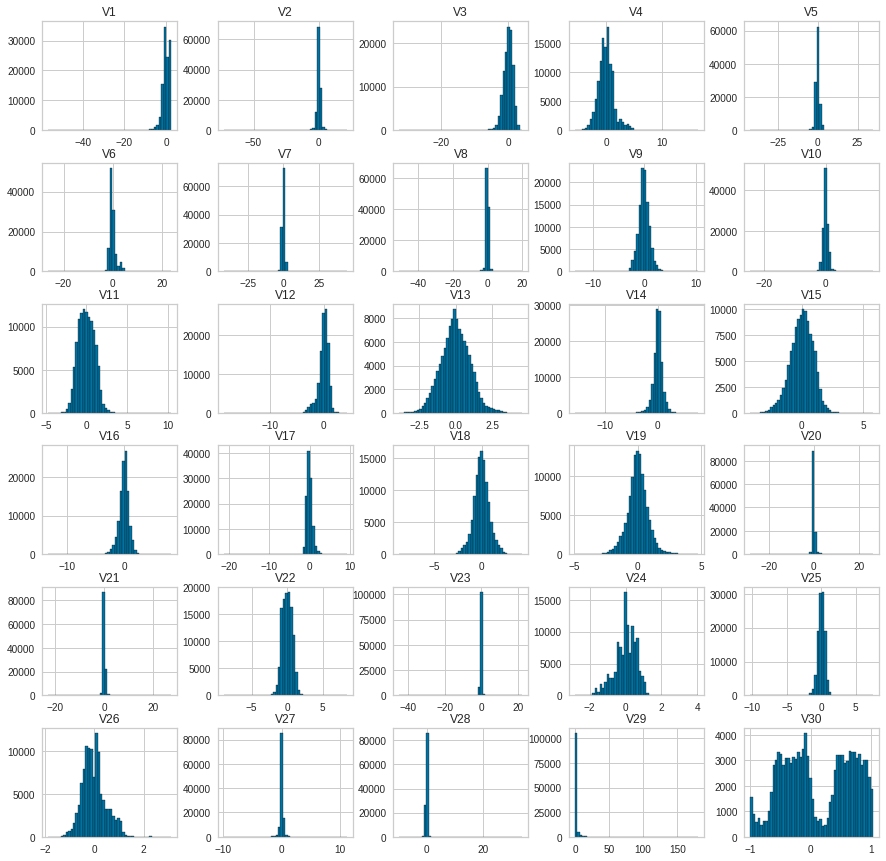

In [14]:
train_df.hist(bins=50, figsize=(15, 15), edgecolor="black")
plt.show()

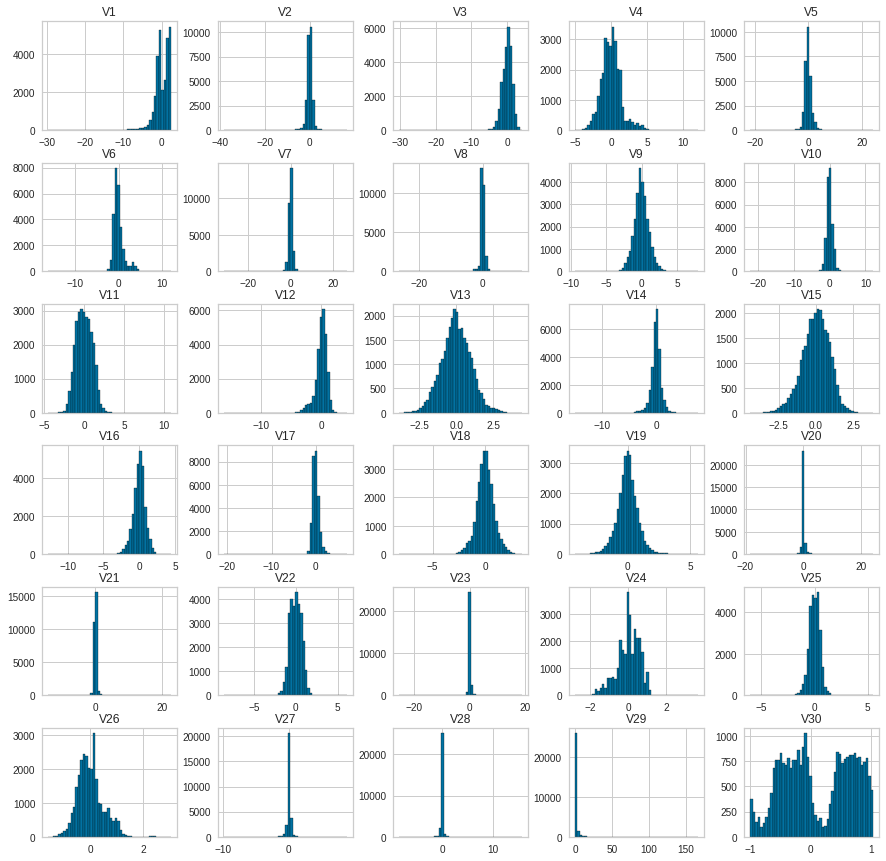

In [16]:
val_df.drop(['Class'], axis=1).hist(bins=50, figsize=(15, 15), edgecolor="black")
plt.show()

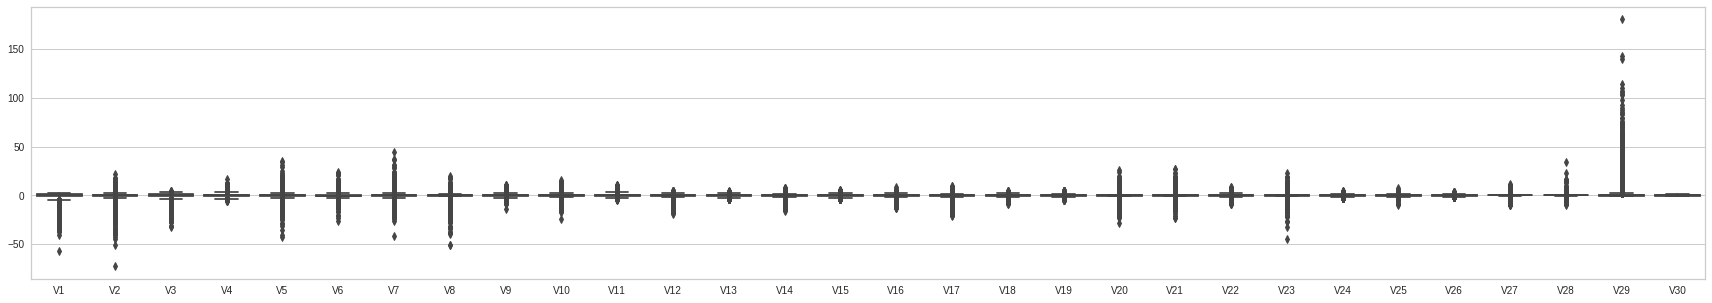

In [20]:
plt.figure(figsize=(30,5))
sns.boxplot(data=train_df)
plt.show()

In [22]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
train_df.corr().style.applymap(color_)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
V1,1.000000,0.015507,-0.015559,0.005334,-0.009902,-0.000177,-0.021839,0.003626,-0.009599,-0.019278,0.003578,-0.011240,0.003362,-0.010310,-0.002944,-0.014766,-0.023218,-0.007048,-0.000303,0.016057,0.000829,-0.001097,0.017551,-0.001289,0.002329,-0.002013,0.004085,-0.044459,-0.231744,0.118519
V2,0.015507,1.000000,0.015350,-0.004632,0.005220,0.004119,0.020025,0.002628,0.001865,0.011013,-0.006297,0.013002,0.001395,0.018952,-0.003989,0.005743,0.021561,0.011934,-0.007469,0.022579,0.010194,0.003269,0.015923,-0.004967,-0.003145,0.000796,0.005265,-0.056137,-0.530737,-0.008336
V3,-0.015559,0.015350,1.000000,0.014562,-0.021869,-0.000392,-0.023424,0.002836,-0.017386,-0.028125,0.014767,-0.031194,-0.000198,-0.027995,-0.000757,-0.025457,-0.043299,-0.014518,-0.000450,0.007484,-0.001319,0.004616,0.001575,0.003254,0.000031,0.000671,0.003680,-0.022925,-0.207185,-0.429787
V4,0.005334,-0.004632,0.014562,1.000000,0.009886,0.001191,0.011269,0.000271,0.008993,0.015209,-0.011847,0.019518,0.000823,0.017077,0.004899,0.016185,0.029483,0.008506,0.000459,-0.013619,-0.000008,-0.002732,-0.004866,0.001741,0.001838,0.002832,-0.007131,0.025828,0.091913,-0.103017
V5,-0.009902,0.005220,-0.021869,0.009886,1.000000,-0.000701,-0.012571,-0.000730,-0.006367,-0.015695,0.012430,-0.016962,0.000159,-0.013393,0.004254,-0.010199,-0.032848,-0.012700,0.003612,-0.013624,-0.013559,0.004033,-0.009856,0.004302,-0.001611,-0.000664,0.020649,-0.004484,-0.382747,0.175038
V6,-0.000177,0.004119,-0.000392,0.001191,-0.000701,1.000000,-0.010017,0.008153,-0.004149,-0.008792,0.002667,-0.008045,0.000016,-0.007086,0.003166,-0.007531,-0.007004,-0.000151,0.000606,0.014117,0.006419,-0.004982,0.004990,-0.001185,-0.000470,-0.003615,-0.011486,0.000046,0.210381,-0.061977
V7,-0.021839,0.020025,-0.023424,0.011269,-0.012571,-0.010017,1.000000,0.000813,-0.009075,-0.033170,0.017100,-0.027035,-0.002328,-0.026328,-0.005088,-0.030188,-0.049680,-0.022684,0.004158,0.027373,0.008721,-0.000123,0.011034,-0.001084,0.000420,0.004651,-0.033952,0.006749,0.391239,0.084646
V8,0.003626,0.002628,0.002836,0.000271,-0.000730,0.008153,0.000813,1.000000,-0.003052,-0.001326,-0.004210,0.008680,0.000216,0.010783,-0.001076,0.006039,0.008411,0.001526,-0.003837,-0.004896,0.001672,0.000508,0.013885,0.000094,-0.003231,0.003217,-0.006134,-0.014922,-0.102777,-0.036350
V9,-0.009599,0.001865,-0.017386,0.008993,-0.006367,-0.004149,-0.009075,-0.003052,1.000000,-0.009130,0.009347,-0.017163,-0.002462,-0.016008,-0.002699,-0.017783,-0.029087,-0.013444,0.002219,-0.000583,-0.007212,-0.002725,-0.008715,0.002114,-0.001449,0.001348,-0.001733,0.008454,-0.041503,-0.007580
V10,-0.019278,0.011013,-0.028125,0.015209,-0.015695,-0.008792,-0.033170,-0.001326,-0.009130,1.000000,0.019515,-0.043050,-0.001893,-0.037438,0.000347,-0.029659,-0.060935,-0.017309,0.007515,0.004115,-0.006280,0.001598,-0.015512,0.004706,-0.000694,-0.000581,-0.005133,0.002669,-0.103121,0.029717


In [49]:
select_feature = ['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V30']
#select_feature_val = ['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V30', 'Class']

train_df = train_df[select_feature]
test_df = test_df[select_feature]
val_df = val[select_feature]

In [45]:
scaler = StandardScaler()
train_df.iloc[:,:] = scaler.fit_transform(train_df)
test_df.iloc[:,:] = scaler.fit_transform(test_df)
val_df.iloc[:,:] = scaler.fit_transform(val_df)

## Models

In [46]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
# https://www.kaggle.com/code/drscarlat/compare-6-unsupervised-anomaly-detection-models

In [47]:
val['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

### Isolation Forest

In [18]:
# isolation forest
IF = IsolationForest(n_estimators=150, max_samples=len(train_df), contamination = val_contamination, max_features = 1, random_state=77)
IF.fit(train_df)

pred = IF.predict(val_df)
y = val['Class']

pred_if = [1 if i==-1 else 0 for i in pred]
val_score = f1_score(y, pred_if, average='macro')

print("Macro f1 score: %.5f" %(val_score))
print(classification_report(y, pred_if))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Macro f1 score: 0.70308
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



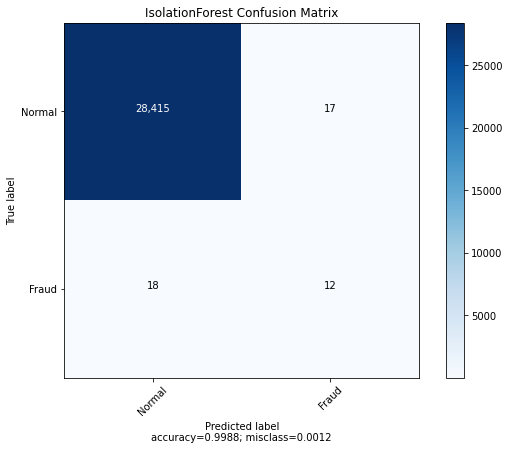

In [32]:
CM=confusion_matrix(y, pred_if)
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "IsolationForest Confusion Matrix")

### Local Outlier Factor

In [21]:
LOF = LocalOutlierFactor(contamination = val_contamination, novelty=True)
LOF.fit(train_df)

pred = LOF.predict(val_df)
y = val['Class'] 

pred_lof = [1 if i==-1 else 0 for i in pred]
val_score = f1_score(y, pred_lof, average='macro')

print("Macro f1 score: %.5f" %(val_score))
print(classification_report(y, pred_lof))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Macro f1 score: 0.49940
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.00      0.00      0.00        30

    accuracy                           1.00     28462
   macro avg       0.50      0.50      0.50     28462
weighted avg       1.00      1.00      1.00     28462



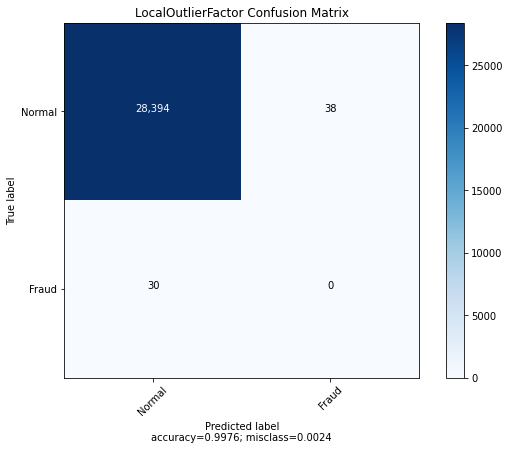

In [31]:
CM=confusion_matrix(y, pred_lof)
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "LocalOutlierFactor Confusion Matrix")

In [50]:
# Optimize LOF hyperparameter n_neighbors for best f1

minRE = 700
maxRE = 1100
    
LofF1 = []

for TryRE in np.arange(minRE, maxRE, 100):
  y = val['Class'] 
  clf = LocalOutlierFactor(n_neighbors=TryRE, contamination = val_contamination, novelty=True)
  clf.fit(train_df)
  y_pred = clf.predict(val_df)
  
  y_pred_lof = [1 if i==-1 else 0 for i in y_pred]
  macro_f1 = f1_score(y, y_pred_lof, average='macro')
  
  print("F1 score on test", round(macro_f1,5), " with num neighbors ", TryRE)
  LofF1.append([TryRE, round(macro_f1,5)])
    
LofF1df = pd.DataFrame(LofF1, columns = ['NumNeighb', 'F1'])
LofF1df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


F1 score on test 0.79289  with num neighbors  700


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


F1 score on test 0.78792  with num neighbors  800


KeyboardInterrupt: ignored

In [ ]:
LofF1df.plot.line("NumNeighb","F1")
plt.xlim(500, 1000)
plt.title("F1 vs NumNeighb")
plt.show()

### Robust Covariance (Elliptic Envelope)

In [26]:
EE = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 42)
EE.fit(train_df)

pred = EE.predict(val_df)
y = val['Class'] 

pred_ee = [1 if i==-1 else 0 for i in pred]
val_score_ee = f1_score(y, pred_ee, average='macro')

print("Macro f1 score: %.5f" %(val_score_ee))
print(classification_report(y, pred_ee))

Macro f1 score: 0.89275
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.85      0.73      0.79        30

    accuracy                           1.00     28462
   macro avg       0.92      0.87      0.89     28462
weighted avg       1.00      1.00      1.00     28462



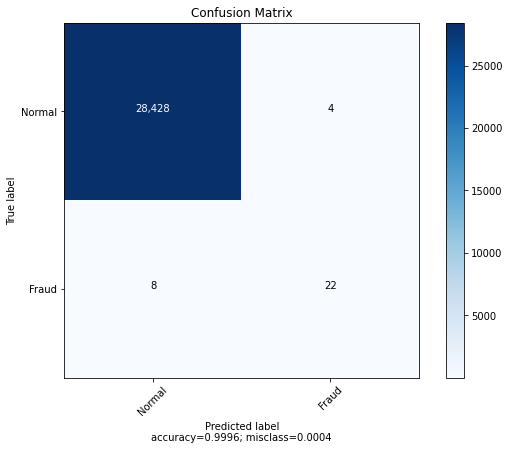

In [30]:
CM=confusion_matrix(y, pred_ee)
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "EllipticEnvelope Confusion Matrix")

In [ ]:
# Optimize EE hyperparameter for best f1

minRE = 0.992
maxRE = 0.998
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 0.002):
  y = val['Class'] 
  cov = EllipticEnvelope(support_fraction = TryRE, contamination = val_contamination)
  cov.fit(train_df)
  y_pred = cov.predict(val_df)
  y_pred_ee = [1 if i==-1 else 0 for i in y_pred]
  macro_f1 = f1_score(y, y_pred_ee, average='macro')
  
  print("F1 score on test", round(macro_f1,5), " with support_fraction ", TryRE)
  EpsF1.append([TryRE, round(macro_f1,5)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['SupFrac', 'F1'])
EpsF1df.head()

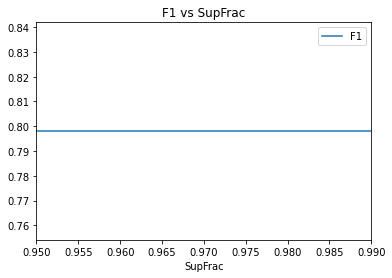

In [37]:
EpsF1df.plot.line("SupFrac","F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs SupFrac")
plt.show()

## Model

In [5]:
anom = setup(train.drop(columns=['ID'], axis=1),
             normalize = True,
             silent = True)

,Description,Value
0,session_id,8170
1,Original Data,"(113842, 30)"
2,Missing Values,False
3,Numeric Features,30
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(113842, 30)"
9,CPU Jobs,-1


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=Non...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='UNSUPERVIS

In [6]:
models()
# iforest, knn, svm, lof, pca

INFO:logs:gpu_param set to False


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [ ]:
# fraction = amount of outliers (assume same as the val dataset)

start_time = time.time()
anom_model = create_model(model = 'iforest',
                         fraction = np.round(val_contamination, 6))
end_time = time.time()
print("Time elapsed: %ds"%(end_time - start_time))

iforest_val_pred = predict_model(anom_model, data = val.drop(columns=['ID', 'Class'], axis=1))


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:IForest(behaviour='new', bootstrap=False, contamination=0.001055,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=6989, verbose=0)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=IForest(behaviour='new', bootstrap=False, contamination=0.001055,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=6989, verbose=0), ml_usecase=MLUsecase.ANOMALY)


Time elapsed: 17s


왜인지 KNN, LOF은 학습이 오래걸림 (5~7분이상)

In [ ]:
start_time = time.time()
anom_model = create_model(model = 'knn',
                         fraction = np.round(val_contamination, 6))
end_time = time.time()
print("Time elapsed: %ds"%(end_time - start_time))

knn_val_pred = predict_model(anom_model, data = val.drop(columns=['ID', 'Class'], axis=1))

INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:KNN(algorithm='auto', contamination=0.001055, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=KNN(algorithm='auto', contamination=0.001055, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0), ml_usecase=MLUsecase.ANOMALY)


Time elapsed: 369s


In [7]:
start_time = time.time()
anom_model = create_model(model = 'lof',
                         fraction = np.round(val_contamination, 6))
end_time = time.time()
print("Time elapsed: %ds"%(end_time - start_time))

lof_val_pred = predict_model(anom_model, data = val.drop(columns=['ID', 'Class'], axis=1))

INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:LOF(algorithm='auto', contamination=0.001055, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=20,
  novelty=True, p=2)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LOF(algorithm='auto', contamination=0.001055, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=20,
  novelty=True, p=2), ml_usecase=MLUsecase.ANOMALY)


Time elapsed: 523s


In [ ]:
results = assign_model(anom_model)
results.head()

In [ ]:
results['Anomaly'].value_counts()

In [ ]:
# plot_model(anom_model, plot = 'umap')

In [ ]:
# check f1 with validation data


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=IForest(behaviour='new', bootstrap=False, contamination=0.0010551491277433877,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=7293, verbose=0), ml_usecase=MLUsecase.ANOMALY)


In [ ]:
val_pred_data = val.drop(columns=['Class'])
val_pred_data['Class'] = iforest_val_pred['Anomaly']
#val_pred_data
y_true = val['Class']
y_pred = val_pred_data['Class']

f1_score(y_true, y_pred, average='macro')

0.6926747205467729

In [ ]:
val_pred_data = val.drop(columns=['Class'])
val_pred_data['Class'] = knn_val_pred['Anomaly']
#val_pred_data
y_true = val['Class']
y_pred = val_pred_data['Class']

f1_score(y_true, y_pred, average='macro')

0.5531318140254624

In [10]:
val_pred_data = val.drop(columns=['Class'], axis=1)
val_pred_data['Class'] = lof_val_pred['Anomaly']
#val_pred_data
y_true = val['Class']
y_pred = val_pred_data['Class']

f1_score(y_true, y_pred, average='macro')

0.4994636230941034

## Prediction

In [ ]:
clf = LocalOutlierFactor(n_neighbors=700, contamination = val_contamination, novelty=True)
clf.fit(train_df)
pred = clf.predict(test_df)
prediction = [1 if i==-1 else 0 for i in pred]

In [ ]:
#pd.set_option('max_rows', 10)
submission = pd.read_csv('sample_submission.csv')
submission['Class'] = prediction
submission

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0
...,...,...
142498,0x4587f,0
142499,0x45880,0
142500,0x45884,0
142501,0x45885,0


In [ ]:
submission['Class'].value_counts()

0    142337
1       166
Name: Class, dtype: int64

In [ ]:
submission.to_csv('sub.csv', index=False)